<a href="https://colab.research.google.com/github/ReyhanehRazavi-99/Facial-Emotion-Recognition/blob/main/ferplus1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A1) Upload kaggle.json (Kaggle → Account → Create New API Token)
from google.colab import files
files.upload()  # choose kaggle.json

# A2) Install Kaggle CLI and place credentials
!pip -q install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Sanity check
!kaggle --version


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


In [ ]:
# Create a target folder and download there
!mkdir -p /content/fer2013plus
!kaggle datasets download -d subhaditya/fer2013plus -p /content/fer2013plus --unzip

# Inspect the contents
!ls -lah /content/fer2013plus


Dataset URL: https://www.kaggle.com/datasets/subhaditya/fer2013plus
License(s): unknown
  0% 0.00/132M [00:00<?, ?B/s]
100% 132M/132M [00:00<00:00, 1.68GB/s]
total 16K
drwxr-xr-x 3 root root 4.0K Oct 10 17:36 .
drwxr-xr-x 1 root root 4.0K Oct 10 17:36 ..
drwxr-xr-x 3 root root 4.0K Oct 10 17:36 fer2013plus
-rw-r--r-- 1 root root 1.8K Oct 10 17:36 ferplus_port.py


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Colab paths (primary) ---
base_path = "/content/fer2013plus/fer2013plus/fer2013"
train_path = os.path.join(base_path, "train")
test_path  = os.path.join(base_path, "test")

# Fallback to /content/fer2013plus if needed
if not (os.path.isdir(train_path) and os.path.isdir(test_path)):
    base_path = "/content/fer2013plus"
    train_path = os.path.join(base_path, "train")
    test_path  = os.path.join(base_path, "test")

assert os.path.isdir(train_path) and os.path.isdir(test_path), \
    f"Couldn't find train/test under {base_path}. Check your folders."

img_size   = (224, 224)
batch_size = 64

# Train (with augmentation) + virtual 20% validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True, seed=1337
)

val_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False, seed=1337
)

test_gen = test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

print("Classes:", train_gen.class_indices)


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Classes: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}


Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Device: cuda
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 230MB/s]
Extracting (test): 100%|██████████| 111/111 [00:06<00:00, 17.13it/s]


Train features: (22712, 9216)  Val: (5674, 9216)  Test: (7099, 9216)

Validation Accuracy: 0.5649
Validation Classification Report:
              precision    recall  f1-score   support

       anger     0.3506    0.4260    0.3846       493
    contempt     0.1000    0.0303    0.0465        33
     disgust     0.0000    0.0000    0.0000        38
        fear     0.3088    0.3231    0.3158       130
   happiness     0.6246    0.6777    0.6501      1505
     neutral     0.6222    0.6114    0.6167      2061
     sadness     0.3754    0.3305    0.3515       702
    surprise     0.6864    0.6180    0.6504       712

    accuracy                         0.5649      5674
   macro avg     0.3835    0.3771    0.3770      5674
weighted avg     0.5624    0.5649    0.5625      5674



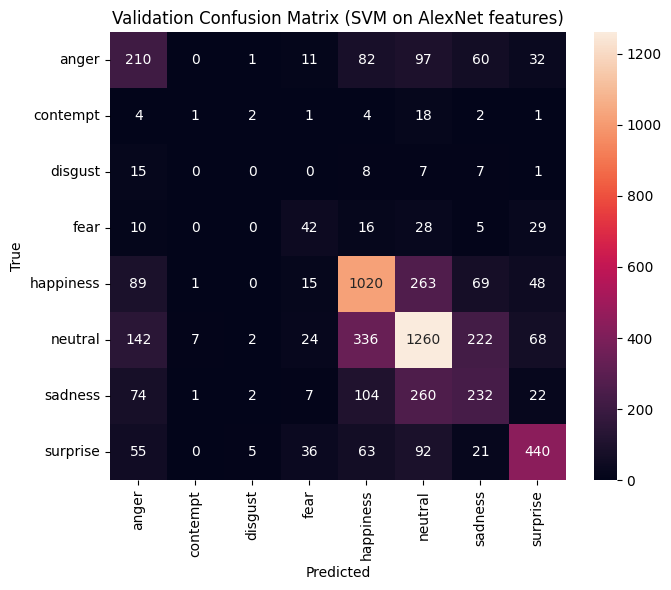


Test Accuracy: 0.6050
Test Classification Report:
              precision    recall  f1-score   support

       anger     0.4253    0.5481    0.4790       644
    contempt     0.1250    0.0196    0.0339        51
     disgust     0.5833    0.1228    0.2029        57
        fear     0.4737    0.2156    0.2963       167
   happiness     0.7004    0.6886    0.6945      1827
     neutral     0.6375    0.6920    0.6636      2597
     sadness     0.3626    0.3084    0.3333       856
    surprise     0.6976    0.6433    0.6694       900

    accuracy                         0.6050      7099
   macro avg     0.5007    0.4048    0.4216      7099
weighted avg     0.6009    0.6050    0.5988      7099



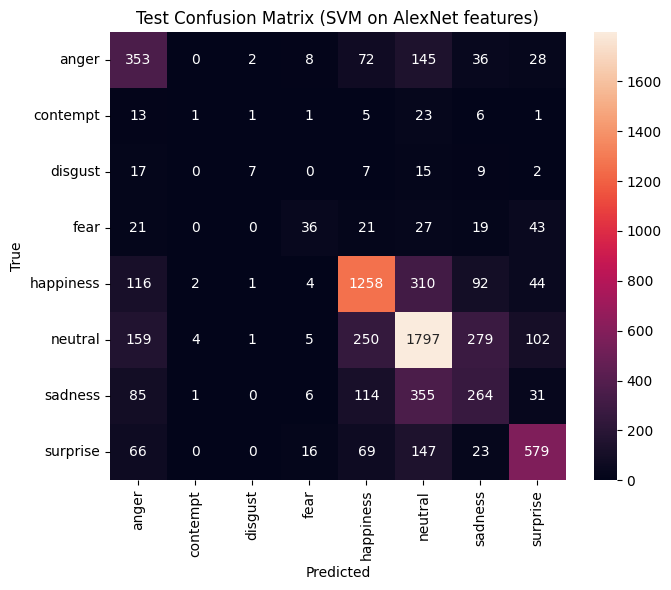

In [ ]:
# ==== AlexNet feature extraction + SVM classifier (uses train_gen / val_gen / test_gen) ====
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Class names from the Keras generator
#    Keras maps classes alphabetically: class_indices = {'anger':0, 'disgust':1, ...}
class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
num_classes = len(class_indices)
print("Classes:", [idx_to_class[i] for i in range(num_classes)])

# 1) Torch device + AlexNet (pretrained) as a pure feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)




_alex = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)  # pretrained on ImageNet
feature_extractor = nn.Sequential(
    _alex.features,   # conv blocks
    _alex.avgpool,    # -> [N, 256, 6, 6]
    nn.Flatten()      # -> [N, 9216]
).to(device).eval()

# ImageNet normalization (Keras generator already did rescale=1/255)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def extract_features_from_generator(gen):
    """
    Loop exactly one 'epoch' of the DirectoryIterator.
    Keras yields RGB float32 in [0,1] due to rescale=1/255.
    We convert to Torch, normalize by ImageNet mean/std, and run AlexNet.
    Returns: X (N, 9216), y (N,)
    """
    gen.reset()
    feats_list, labels_list = [], []

    # len(gen) = number of batches per epoch
    for _ in tqdm(range(len(gen)), desc=f"Extracting ({gen.subset or 'test'})"):
        X_np, y_np = next(gen)                       # X: (B,H,W,3) float32 in [0,1]; y: one-hot (B,num_classes)
        y_idx = np.argmax(y_np, axis=1).astype("int64")

        # to torch [B,3,224,224]
        x = torch.from_numpy(X_np).permute(0,3,1,2).to(device)
        # normalize for ImageNet
        x = (x - IMAGENET_MEAN) / IMAGENET_STD

        with torch.no_grad():
            f = feature_extractor(x).detach().cpu().numpy()  # (B, 9216)

        feats_list.append(f)
        labels_list.append(y_idx)

    X = np.vstack(feats_list) if feats_list else np.empty((0, 9216), dtype=np.float32)
    y = np.concatenate(labels_list) if labels_list else np.empty((0,), dtype=np.int64)
    return X, y

# 2) Build (X, y) for train / val / test
X_train, y_train = extract_features_from_generator(train_gen)
X_val,   y_val   = extract_features_from_generator(val_gen)
X_test,  y_test  = extract_features_from_generator(test_gen)

print("Train features:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# 3) SVM classifier (with feature scaling)
svm = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(kernel="linear", C=1.0, class_weight="balanced", probability=False, random_state=42)
)
svm.fit(X_train, y_train)

# 4) Evaluate on validation AND test
def eval_split(name, X, y):
    y_pred = svm.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    target_names = [idx_to_class[i] for i in sorted(set(y))]
    print(f"{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=target_names, digits=4))

    cm = confusion_matrix(y, y_pred, labels=sorted(set(y)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=[idx_to_class[i] for i in sorted(set(y))],
                yticklabels=[idx_to_class[i] for i in sorted(set(y))])
    plt.title(f"{name} Confusion Matrix (SVM on AlexNet features)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

eval_split("Validation", X_val, y_val)
eval_split("Test",       X_test, y_test)


In [ ]:
# ==== Export AlexNet+SVM artifacts for local inference (Colab) ====
import os, json, zipfile, joblib, torch, gc
from sklearn import __version__ as sklearn_version
import torch.nn as nn
from torchvision.models import alexnet, AlexNet_Weights

# Folder for artifacts
ARTI = "/content/alexnet_svm_artifacts"
os.makedirs(ARTI, exist_ok=True)

# 1) Save the trained SVM pipeline (StandardScaler + SVC)
svm_path = os.path.join(ARTI, "svm_alexnet_pipeline.joblib")
joblib.dump(svm, svm_path, compress=3)
print("Saved:", svm_path)

# 2) Save class names in the exact index order used
class_names = [idx_to_class[i] for i in range(num_classes)]
with open(os.path.join(ARTI, "classes.json"), "w") as f:
    json.dump({"class_names": class_names}, f, indent=2)
print("Saved:", os.path.join(ARTI, "classes.json"))

# 3) Save a TorchScript feature extractor so local code doesn't re-download weights
#    (AlexNet pretrained on ImageNet, same as used for feature extraction: features+avgpool+Flatten -> 9216-D)
alex_cpu = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
feature_extractor_cpu = nn.Sequential(
    alex_cpu.features,
    alex_cpu.avgpool,
    nn.Flatten()
).eval()  # CPU + eval

ts_path = os.path.join(ARTI, "alexnet_features_scripted.pt")
try:
    scripted = torch.jit.script(feature_extractor_cpu)
    scripted.save(ts_path)
    print("Saved TorchScript (script):", ts_path)
except Exception as e:
    print("Scripting failed, falling back to trace:", e)
    example = torch.randn(1, 3, 224, 224)
    traced = torch.jit.trace(feature_extractor_cpu, example)
    traced.save(ts_path)
    print("Saved TorchScript (trace):", ts_path)

# Free RAM
del alex_cpu, feature_extractor_cpu
gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

# 4) Save metadata describing preprocessing and model setup
meta = {
    "pipeline": "alexnet_features + StandardScaler + SVC",
    "arch": "alexnet",
    "feature_dim": 9216,
    "input_size": [3, 224, 224],
    "imagenet_mean": [0.485, 0.456, 0.406],
    "imagenet_std":  [0.229, 0.224, 0.225],
    "svm": {
        "sklearn_version": sklearn_version,
        "kernel": "linear",
        "C": 1.0,
        "class_weight": "balanced",
        "probability": False,
        "random_state": 42
    },
    "notes": "Keras generator rescaled images to [0,1]; local inference must do the same then normalize with mean/std above."
}
with open(os.path.join(ARTI, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:", os.path.join(ARTI, "meta.json"))

# 5) Zip and download
zip_path = "/content/alexnet_svm_artifacts.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for name in os.listdir(ARTI):
        z.write(os.path.join(ARTI, name), arcname=name)
print("Bundle:", zip_path)

from google.colab import files
files.download(zip_path)


Saved: /content/alexnet_svm_artifacts/svm_alexnet_pipeline.joblib
Saved: /content/alexnet_svm_artifacts/classes.json
Saved TorchScript (script): /content/alexnet_svm_artifacts/alexnet_features_scripted.pt
Saved: /content/alexnet_svm_artifacts/meta.json
Bundle: /content/alexnet_svm_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Device: cuda | Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 215MB/s]


Epoch 1/20 | Batch 0/355 | Loss 2.1631
Epoch 1/20 | Batch 100/355 | Loss 1.1243
Epoch 1/20 | Batch 200/355 | Loss 1.1681
Epoch 1/20 | Batch 300/355 | Loss 0.9626
Epoch 01 | Train Loss 1.2049 Acc 61.25% | Val Loss 1.0368 Acc 68.38%
✓ Saved: alexnet_finetuned_best.pth
Epoch 2/20 | Batch 0/355 | Loss 0.9137
Epoch 2/20 | Batch 100/355 | Loss 1.0185
Epoch 2/20 | Batch 200/355 | Loss 1.0275
Epoch 2/20 | Batch 300/355 | Loss 0.7798
Epoch 02 | Train Loss 0.9756 Acc 71.07% | Val Loss 0.9296 Acc 72.54%
✓ Saved: alexnet_finetuned_best.pth
Epoch 3/20 | Batch 0/355 | Loss 1.0416
Epoch 3/20 | Batch 100/355 | Loss 0.7518
Epoch 3/20 | Batch 200/355 | Loss 0.8342
Epoch 3/20 | Batch 300/355 | Loss 0.9531
Epoch 03 | Train Loss 0.9034 Acc 74.01% | Val Loss 0.8688 Acc 74.92%
✓ Saved: alexnet_finetuned_best.pth
Epoch 4/20 | Batch 0/355 | Loss 0.8200
Epoch 4/20 | Batch 100/355 | Loss 0.8662
Epoch 4/20 | Batch 200/355 | Loss 0.7781
Epoch 4/20 | Batch 300/355 | Loss 0.9259
Epoch 04 | Train Loss 0.8385 Acc 76.5

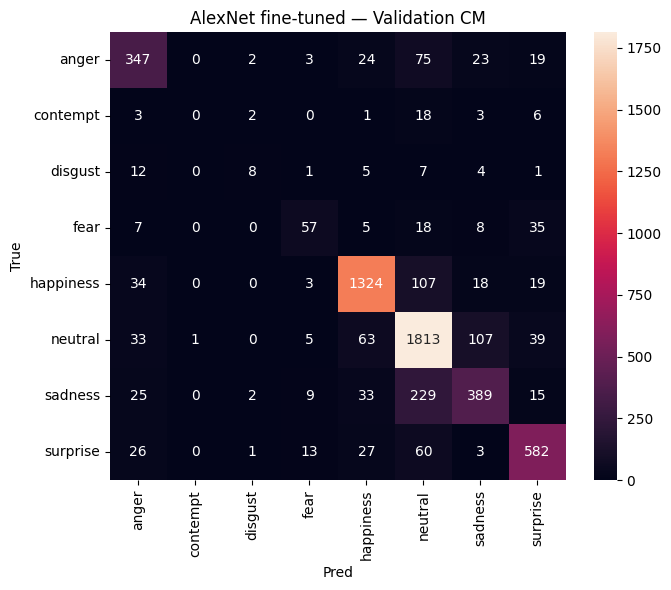


TEST | loss 0.7546 acc 79.86%
              precision    recall  f1-score   support

       anger     0.7410    0.7329    0.7369       644
    contempt     0.0000    0.0000    0.0000        51
     disgust     0.5000    0.2456    0.3294        57
        fear     0.5946    0.3952    0.4748       167
   happiness     0.8998    0.8949    0.8974      1827
     neutral     0.7922    0.8645    0.8267      2597
     sadness     0.6210    0.6145    0.6177       856
    surprise     0.8618    0.7900    0.8243       900

    accuracy                         0.7986      7099
   macro avg     0.6263    0.5672    0.5884      7099
weighted avg     0.7907    0.7986    0.7931      7099



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


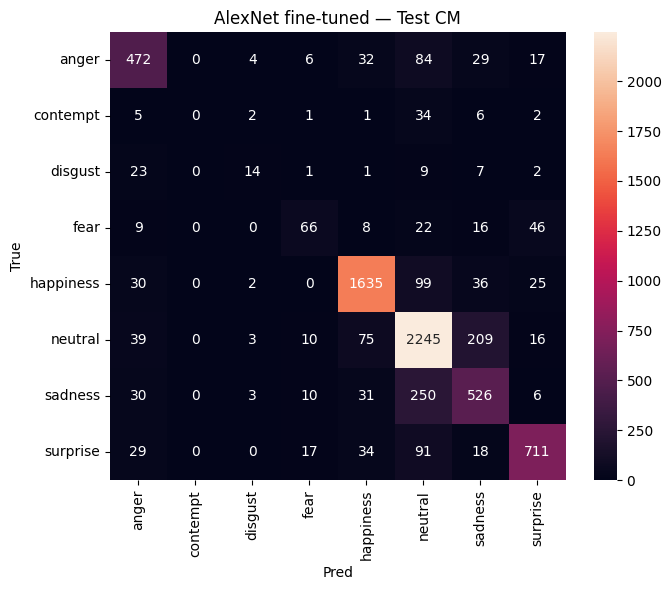

In [ ]:
# ==== AlexNet fine-tuning (end-to-end) on FERPlus using Keras generators ====
import numpy as np, torch, torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 0) Classes / device
class_indices = train_gen.class_indices                 # {'anger':0, 'contempt':1, ...}
idx_to_class  = {v:k for k,v in class_indices.items()}
class_names   = [idx_to_class[i] for i in range(len(class_indices))]
num_classes   = len(class_indices)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| Classes:", class_names)

# 1) Build AlexNet and replace final classifier head
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
# AlexNet classifier = [Dropout, Linear(9216->4096), ReLU, Dropout, Linear(4096->4096), ReLU, Linear(4096->1000)]
in_features = model.classifier[6].in_features          # 4096
model.classifier[6] = nn.Linear(in_features, num_classes)
model = model.to(device)

# Optional: if you want to freeze early convs (uncomment next lines)
# for p in model.features.parameters():
#     p.requires_grad = False

# 2) Loss / optimizer / scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# 3) ImageNet normalization (your gens already rescale to [0,1])
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def _batch_from_keras(X_np, y_np):
    # X_np: (B,H,W,3) float32 in [0,1], y_np: one-hot (B,C)
    x = torch.from_numpy(X_np).permute(0,3,1,2).to(device)
    x = (x - IMAGENET_MEAN) / IMAGENET_STD
    y = torch.from_numpy(np.argmax(y_np, axis=1)).long().to(device)
    return x, y

class KerasTorchLoader:
    def __init__(self, keras_gen):
        self.gen = keras_gen
        self._len = len(keras_gen)
    def __len__(self): return self._len
    def __iter__(self):
        self.gen.reset()
        for _ in range(self._len):
            X_np, y_np = next(self.gen)
            yield _batch_from_keras(X_np, y_np)

train_loader = KerasTorchLoader(train_gen)
val_loader   = KerasTorchLoader(val_gen)
test_loader  = KerasTorchLoader(test_gen)

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_labels = [], []
    for x,y in loader:
        out = model(x)
        loss = criterion(out, y)
        loss_sum += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())
    avg_loss = loss_sum / max(1,total)
    acc = correct / max(1,total)
    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_labels, all_preds

def train_model(model, epochs=20, patience=3, print_every=100):
    best_val_loss = float('inf')
    wait = 0
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_state = None

    for ep in range(1, epochs+1):
        # ---- Train ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for b,(x,y) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total   += y.size(0)
            if b % print_every == 0:
                print(f"Epoch {ep}/{epochs} | Batch {b}/{len(train_loader)} | Loss {loss.item():.4f}")

        scheduler.step()
        train_loss = running_loss / max(1,len(train_loader))
        train_acc  = correct / max(1,total)

        # ---- Validate ----
        val_loss, val_acc, _, _ = evaluate(val_loader, model)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {ep:02d} | Train Loss {train_loss:.4f} Acc {train_acc*100:.2f}% "
              f"| Val Loss {val_loss:.4f} Acc {val_acc*100:.2f}%")

        # early stopping on val loss
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            wait = 0
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            torch.save({
                "epoch": ep,
                "model_state_dict": best_state,
                "optimizer_state_dict": optimizer.state_dict(),
                "class_names": class_names
            }, "alexnet_finetuned_best.pth")
            print("✓ Saved: alexnet_finetuned_best.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping — restoring best weights.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# ---- Train ----
history = train_model(model, epochs=20, patience=3)

# ---- Evaluate on validation & test ----
val_loss, val_acc, yv, pv = evaluate(val_loader, model)
print(f"\nVAL  | loss {val_loss:.4f} acc {val_acc*100:.2f}%")
print(classification_report(yv, pv, target_names=class_names, digits=4))
cmv = confusion_matrix(yv, pv)
plt.figure(figsize=(7,6)); sns.heatmap(cmv, annot=True, fmt="d",
    xticklabels=class_names, yticklabels=class_names)
plt.title("AlexNet fine-tuned — Validation CM"); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

test_loss, test_acc, yt, pt = evaluate(test_loader, model)
print(f"\nTEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")
print(classification_report(yt, pt, target_names=class_names, digits=4))
cmt = confusion_matrix(yt, pt)
plt.figure(figsize=(7,6)); sns.heatmap(cmt, annot=True, fmt="d",
    xticklabels=class_names, yticklabels=class_names)
plt.title("AlexNet fine-tuned — Test CM"); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()


In [ ]:
# ==== Export fine-tuned AlexNet artifacts for local webcam inference ====
import os, json, zipfile, torch, gc
from google.colab import files

ARTI = "/content/alexnet_finetuned_artifacts"
os.makedirs(ARTI, exist_ok=True)

# 1) Save full training checkpoint (best already saved during training)
best_ckpt_path = os.path.join(ARTI, "alexnet_finetuned_best.pth")
if os.path.exists("alexnet_finetuned_best.pth"):
    torch.save(torch.load("alexnet_finetuned_best.pth", map_location="cpu"), best_ckpt_path)
else:
    # Save current state as a fallback
    torch.save({
        "epoch": -1,
        "model_state_dict": model.state_dict(),
        "class_names": class_names
    }, best_ckpt_path)
print("Saved:", best_ckpt_path)

# 2) Save TorchScript inference model (forward logits)
model_cpu = alexnet(weights=None)
in_features = model_cpu.classifier[6].in_features
model_cpu.classifier[6] = nn.Linear(in_features, num_classes)
# load best weights
state = torch.load(best_ckpt_path, map_location="cpu")
state_dict = state["model_state_dict"] if "model_state_dict" in state else state
model_cpu.load_state_dict(state_dict, strict=True)
model_cpu.eval()

ts_path = os.path.join(ARTI, "alexnet_finetuned_scripted.pt")
try:
    scripted = torch.jit.script(model_cpu)
    scripted.save(ts_path)
    print("Saved TorchScript (script):", ts_path)
except Exception as e:
    print("Scripting failed, falling back to trace:", e)
    example = torch.randn(1,3,224,224)
    traced = torch.jit.trace(model_cpu, example)
    traced.save(ts_path)
    print("Saved TorchScript (trace):", ts_path)

# 3) Save class names
with open(os.path.join(ARTI, "classes.json"), "w") as f:
    json.dump({"class_names": class_names}, f, indent=2)
print("Saved classes.json")

# 4) Save preprocessing meta
meta = {
    "pipeline": "alexnet finetuned softmax",
    "arch": "alexnet",
    "input_size": [3,224,224],
    "imagenet_mean": [0.485, 0.456, 0.406],
    "imagenet_std":  [0.229, 0.224, 0.225],
    "notes": "Inputs must be RGB float in [0,1], then normalized with mean/std above."
}
with open(os.path.join(ARTI, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta.json")

# 5) Bundle for download
zip_path = "/content/alexnet_finetuned_artifacts.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for name in os.listdir(ARTI):
        z.write(os.path.join(ARTI, name), arcname=name)
print("Bundle:", zip_path)
files.download(zip_path)

# Cleanup
del model_cpu; gc.collect()


Saved: /content/alexnet_finetuned_artifacts/alexnet_finetuned_best.pth
Saved TorchScript (script): /content/alexnet_finetuned_artifacts/alexnet_finetuned_scripted.pt
Saved classes.json
Saved meta.json
Bundle: /content/alexnet_finetuned_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

411